In [202]:
import pandas as pd
import geopandas as gpd
import numpy as np
import urllib
import glob
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import shapely
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from geopandas.tools import sjoin
from fiona.crs import from_epsg
from math import sin, cos, sqrt, atan2
import mapclassify as mc
import rtree
import math
import patsy
import libpysal as lps
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
url = 'https://raw.githubusercontent.com/lavsz/dsc-mod-2-project-v2-1-onl01-dtsc-pt-052620/master/kc_house_data.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# <span style="color:##FF1493"> 1. Clean and formatting </span>
Waterfront, Basement, Renovating year Values, Date

## 1.1 Waterfront

In [6]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [7]:
# Water front
# Based on King's County's map
# we assume that if any houses with nan value fall within the follow zips
# Are going to assign a 1, otherwise 0 
water_zip = [98177, 98117, 98199, 98119, 98121, 
             98101, 98104, 98134, 98126, 98116, 
             98136, 98136, 98166, 98196, 98070]
df['waterfront_adj'] = df['waterfront']
for i in range(len(df)):
    if np.isnan(df['waterfront_adj'][i]) == 1:
        if df.zipcode[i] in water_zip:
            df['waterfront_adj'][i] = 1
        elif df.zipcode[i] not in water_zip:
            df['waterfront_adj'][i] = 0
        else:
            df['waterfront_adj'][i] = df.waterfront[i]

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## 1.2 Basement Square Footage

In [8]:
# Basement sqft is object is very odd
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [9]:
# replace the '?' with -1 first
# change the dtype to float
df.sqft_basement = df.sqft_basement.str.replace('?', '0.0')
df.sqft_basement = df.sqft_basement.astype(float)

## 1.3 Renovating years

In [10]:
# renovating years
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [11]:
# replace nan with just 0 
df.yr_renovated = df.yr_renovated.fillna(0)
df.yr_renovated.unique()

array([   0., 1991., 2002., 2010., 1992., 2013., 1994., 1978., 2005.,
       2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990., 1988.,
       1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955., 1982.,
       1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1967., 1965., 1934., 1972., 1944., 1958.])

## 1.4 Sales date

In [12]:
# Sales data to datetime format
# Easy to extract month, year, weekdays for further analysis
df.date = pd.to_datetime(df.date, format='%m/%d/%Y')

## 1.5 Views

In [13]:
df.view = df.view.fillna(0)

# <span style="color:##FF1493"> 3. Finding outliers </span>

In [14]:
with pd.option_context('display.max_columns', 40):
    print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233181      3.409825   
std    4.141264e+04      0.539683      0.086825    

In [15]:
# 33 bedrooms seems very odd and need to check out the size of the house
bed_33 = df[df.bedrooms == 33]
bed_33

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_adj
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,0.0


In [16]:
# Based on the number of bathrooms, living sqft, it is definitely a typo
# The value will be corrected to 3 instead
df.bedrooms = df.bedrooms.replace({33: 3})

In [26]:
# How are other ones look like
duplicates_else = duplicates_else.sort_values(by=['id', 'date'])
duplicates_else_group = duplicates_else.groupby('id').diff().fillna(0)
duplicates_else_diff = duplicates_else_group.loc[:, (duplicates_else_group != 0).any(axis=0)]
duplicates_else_diff.waterfront_adj.value_counts(), duplicates_else_diff.sqft_basement.value_counts(), duplicates_else_diff.price.value_counts()


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


( 0.0    347
  1.0      2
 -1.0      1
 Name: waterfront_adj, dtype: int64, 0.0      349
 700.0      1
 Name: sqft_basement, dtype: int64, 0.0         178
 110000.0      4
 220000.0      3
 65000.0       3
 130000.0      3
            ... 
 125900.0      1
 110950.0      1
 165710.0      1
 107500.0      1
 211000.0      1
 Name: price, Length: 143, dtype: int64)

In [27]:
df['FAR'] = (df.sqft_living/df.floors)/df.sqft_lot
df['bd_ba_ratio'] = df.bedrooms/df.bathrooms
df['age'] = df.date.dt.year - df.yr_built
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront_adj', 'FAR',
       'bd_ba_ratio', 'age'],
      dtype='object')

## Colinearity

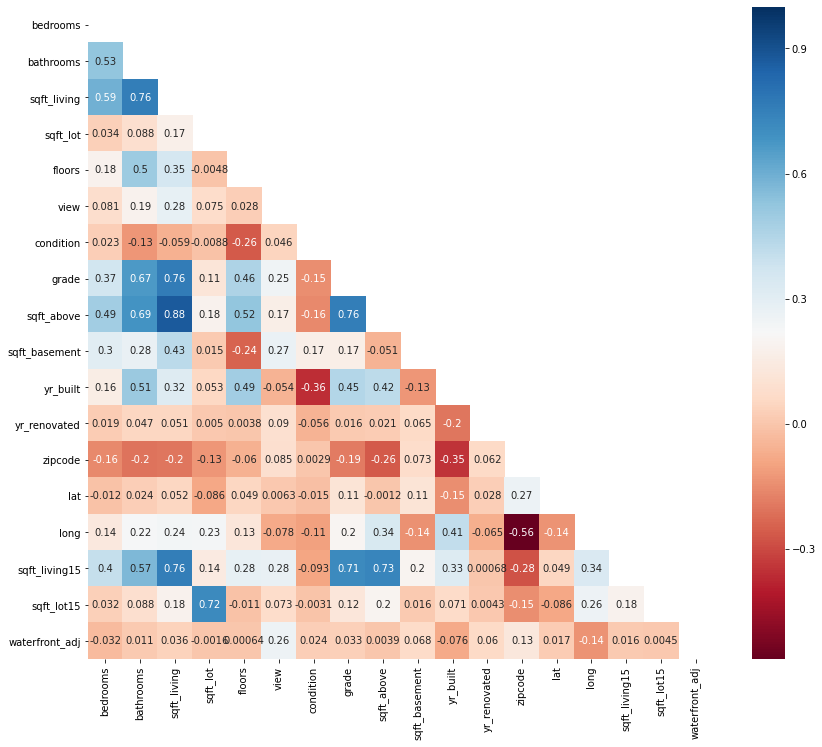

In [18]:
plt.figure(figsize=(14,12))
df_var = df.drop(['price', 'id', 'waterfront'], axis=1)
corr = df_var.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu', annot = True)
# 0.7 is a threshold; 

## Interpretations: 
**sqft_living15 & sqft_above** - seems to have strong correlation with many features
<br/>
**sqft_lot15** - not likely going to use it
<br/>
**yr_built** - derived age; and will be dropped
<br/>
**bathroom & bedroom ** - have strong correlation with some features - can be turn into a categorical feature
<br/>
**bd_ba_ratio** - is probably not a good representation as 6 vs 4 and 3 vs 2 have the same ratio but different numbers

In [19]:
df['bed:bath'] = df['bedrooms'].astype(str) + ' : ' + df['bathrooms'].astype(str)

In [22]:
df_clean = df.drop(['waterfront', 'sqft_living15', 'sqft_above', 'sqft_lot15',
                    'yr_built', 'bathrooms', 'bedrooms'], axis=1)

In [26]:
df_clean['FAR'] = df_clean.sqft_living/df_clean.sqft_lot

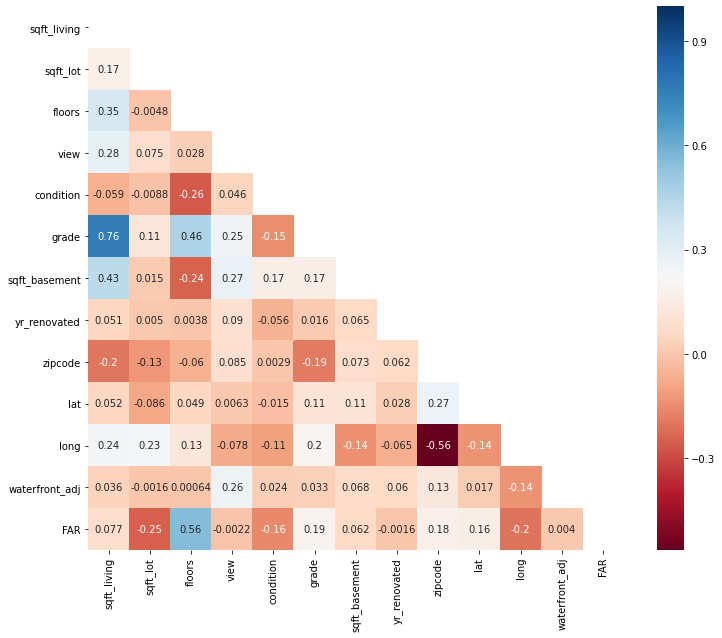

In [27]:
plt.figure(figsize=(12,10))
df_clean_v = df_clean.drop(['price', 'id'], axis=1)
corr_v = df_clean_v.corr()
mask = np.triu(np.ones_like(corr_v, dtype=np.bool))
sns.heatmap(corr_v, mask=mask,
        xticklabels=corr_v.columns,
        yticklabels=corr_v.columns, cmap='RdBu', annot = True)

## Interpretation: 
Age might be not easy to interpret when it comes to dealing with price but condition can possibly speak more.

In [31]:
# getting month & seanson features from data
df_clean['month'] = df_clean.date.dt.month
df_clean['season'] = ' '
df_clean.loc[df_clean.month.isin([3,4,5]), 'season'] = 'Spring'
df_clean.loc[df_clean.month.isin([6,7,8]), 'season'] = 'Summer'
df_clean.loc[df_clean.month.isin([9,10,11]), 'season'] = 'Fall'
df_clean.loc[df_clean.month.isin([12,1,2]), 'season'] = 'Winter'

In [83]:
# change a few features to integer to avoid naming issues
df_clean.view = df_clean.view.astype(int)
df_clean.waterfront_adj = df_clean.waterfront_adj.astype(int)
df_clean.condition = df_clean.condition.astype(int)

# Q3: Marketing and time-series (multivariate, conditional linear reg) can include but not limited to:
Monthly trend of sales amount, price, house features
<br/>
Seasonal trend of neighbourhood features (perhaps people like to look at waterfront houses in Summer)
<br/>
Categorize features from neighbourhood and generalize overall price for neighbourhoods (spatial lag correction can imply)
<br/>

In [84]:
# Seasonal dataset
df_marking = df_clean[['id', 'date', 'price', 'sqft_living',
       'sqft_lot', 'view', 'condition', 'grade',
       'lat', 'long', 'waterfront_adj',
       'season', 'FAR', 'bed:bath']]

In [85]:
# Demographic and District
demographic = 'https://opendata.arcgis.com/datasets/e23a07e847a7440dabac76ede52b521d_2687.zip'
urllib.request.urlretrieve(demographic, 'demo_file.gz')
!mkdir demographic
!unzip -d demographic demo_file.gz
demos = gpd.GeoDataFrame.from_file(glob.glob("demographic/*.shp")[0])

mkdir: demographic: File exists
Archive:  demo_file.gz
replace demographic/Consolidated_Demographics_Index_for_King_County_Census_Tracts___demographic_index_area.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [86]:
df_marking.season.unique()

array(['Fall', 'Winter', 'Spring', 'Summer'], dtype=object)

In [87]:
# Turning into categorical data
df_marking.season = df_marking.season.astype('category')
df_marking.grade = df_marking.grade.astype('category')
df_marking['bed:bath'] = df_marking['bed:bath'].astype('category')
df_marking.waterfront_adj = df_marking.waterfront_adj.astype('category')
df_marking.view = df_marking.view.astype('category')
df_marking.condition = df_marking.condition.astype('category')

# Making dummies
season = pd.get_dummies(df_marking.season, prefix='season', drop_first=True)
grade = pd.get_dummies(df_marking.grade, prefix='grade', drop_first=True)   
bed_bath = pd.get_dummies(df_marking['bed:bath'], prefix='bb_ratio', drop_first=True)
wat = pd.get_dummies(df_marking.waterfront_adj, prefix='waterfront', drop_first=True)
view = pd.get_dummies(df_marking.view, prefix='view', drop_first=True)
condition = pd.get_dummies(df_marking.condition, prefix='condition', drop_first=True)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [90]:
df_marking_a = df_marking.join([season, grade, condition, wat, view])
df_marking_analysis = df_marking_a.drop(['grade', 'view', 'bed:bath',
                                         'season', 'waterfront_adj', 'condition'], axis=1)
df_marking_analysis.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'lat', 'long', 'FAR',
       'season_Spring', 'season_Summer', 'season_Winter', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11',
       'grade_12', 'grade_13', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'waterfront_1', 'view_1', 'view_2', 'view_3', 'view_4'],
      dtype='object')

In [91]:
target = 'price'
predictors = df_marking_analysis.drop(['id', 'price', 'date', 'lat', 'long'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_c_base = ols(formula=formula, data=df_marking_analysis).fit()
model_c_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1556.
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:12:36   Log-Likelihood:            -2.9626e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21571   BIC:                         5.928e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.762e+04   2.23e+05      0.392      0.695    -3.5e+05    5.26e+05
sqft_living     143.4679      2.622     54.714      0.000     138.328     148.607
sqft_lot         -0.1463      0.038     -3.828      0.000      -0.221      -0.071
FAR            1.094e+05   6171.312     17.725      0.000    9.73e+04    1.21e+05
season_Spring   2.72e+04   4117.509      6.607      0.000    1.91e+04    3.53e+04
season_Summer  2578.3955   4146.670      0.622      0.534   -5549.385    1.07e+04
season_Winter -4913.9735   4755.371     -1.033      0.301   -1.42e+04    4406.905
grade_4        1212.5129   2.24e+05      0.005      0.996   -4.37e+05     4.4e+05
grade_5       -2.554e+04    2.2e+05     -0.116      0.908   -4.57e+05    4.06e+05
grade_6         613.6472    2.2e+05      0.003      0.998    -4.3e+05    4.31e+05
grade_7        2.651e+04    2.2e+05      0.121      0.904   -4.04e+05    4.57e+05
grade_8        8.009e+04    2.2e+05      0.365      0.715   -3.51e+05    5.11e+05
grade_9        2.076e+05    2.2e+05      0.945      0.345   -2.23e+05    6.38e+05
grade_10        4.01e+05    2.2e+05      1.824      0.068      -3e+04    8.32e+05
grade_11       6.744e+05    2.2e+05      3.063      0.002    2.43e+05    1.11e+06
grade_12       1.161e+06   2.21e+05      5.248      0.000    7.28e+05     1.6e+06
grade_13       2.386e+06   2.29e+05     10.434      0.000    1.94e+06    2.83e+06
condition_2   -1.617e+04   4.42e+04     -0.366      0.715   -1.03e+05    7.06e+04
condition_3   -3.332e+04   4.11e+04     -0.810      0.418   -1.14e+05    4.73e+04
condition_4    2.807e+04   4.12e+04      0.682      0.495   -5.26e+04    1.09e+05
condition_5    1.022e+05   4.14e+04      2.469      0.014    2.11e+04    1.83e+05
waterfront_1   1.977e+05   1.14e+04     17.335      0.000    1.75e+05     2.2e+05
view_1         1.601e+05   1.22e+04     13.071      0.000    1.36e+05    1.84e+05
view_2         9.591e+04   7382.139     12.992      0.000    8.14e+04     1.1e+05
view_3          1.67e+05   1.01e+04     16.586      0.000    1.47e+05    1.87e+05
view_4         4.411e+05   1.36e+04     32.526      0.000    4.15e+05    4.68e+05
==============================================================================
Omnibus:                    13135.157   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           503945.310
Skew:                           2.337   Prob(JB):                         0.00
Kurtosis:                      26.199   Cond. No.                     2.15e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+07. This might indicate that there are
strong multicollinearity or other numerical prob

## Indication:
Overall condition and grades P values are high, might consider dropping this feature

In [94]:
df_marking_a = df_marking.join([season, wat, view])
df_marking_analysis = df_marking_a.drop(['grade', 'view', 'bed:bath',
                                         'season', 'waterfront_adj', 'condition'], axis=1)
df_marking_analysis.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'lat', 'long', 'FAR',
       'season_Spring', 'season_Summer', 'season_Winter', 'waterfront_1',
       'view_1', 'view_2', 'view_3', 'view_4'],
      dtype='object')

In [95]:
target = 'price'
predictors = df_marking_analysis.drop(['id', 'price', 'date', 'lat', 'long'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_c_base = ols(formula=formula, data=df_marking_analysis).fit()
model_c_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2448.
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:15:15   Log-Likelihood:            -2.9865e+05
No. Observations:               21597   AIC:                         5.973e+05
Df Residuals:                   21585   BIC:                         5.974e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.591e+04   5454.535    -10.250      0.000   -6.66e+04   -4.52e+04
sqft_living     256.4742      1.937    132.377      0.000     252.677     260.272
sqft_lot         -0.1342      0.043     -3.153      0.002      -0.218      -0.051
FAR            9.737e+04   6478.932     15.029      0.000    8.47e+04     1.1e+05
season_Spring  2.623e+04   4593.615      5.710      0.000    1.72e+04    3.52e+04
season_Summer  5857.4056   4625.374      1.266      0.205   -3208.669    1.49e+04
season_Winter -6816.0077   5305.494     -1.285      0.199   -1.72e+04    3583.152
waterfront_1   2.019e+05   1.27e+04     15.864      0.000    1.77e+05    2.27e+05
view_1         1.646e+05   1.37e+04     12.052      0.000    1.38e+05    1.91e+05
view_2         1.217e+05   8220.760     14.805      0.000    1.06e+05    1.38e+05
view_3         2.072e+05   1.12e+04     18.474      0.000    1.85e+05    2.29e+05
view_4         5.362e+05    1.5e+04     35.630      0.000    5.07e+05    5.66e+05
==============================================================================
Omnibus:                    14160.800   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           576827.341
Skew:                           2.599   Prob(JB):                         0.00
Kurtosis:                      27.779   Cond. No.                     4.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
df_condition = df[['id', 'price', 'sqft_living', 'lat', 'long', 'waterfront_adj', 'view', 'condition', 'grade']]

In [71]:
df_price_clean['$/sqft'] = df_price_clean.price/df_price_clean.sqft_living

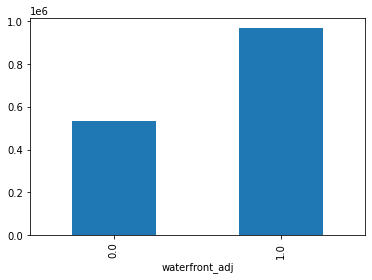

In [43]:
df_condition.price.groupby(df_condition.waterfront_adj).mean().plot(kind='bar')

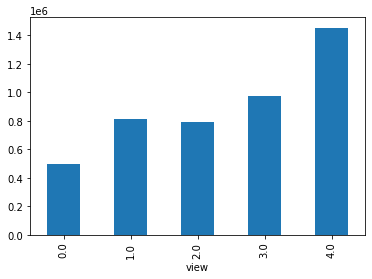

In [44]:
df_condition.price.groupby(df_condition.view).mean().plot(kind='bar')

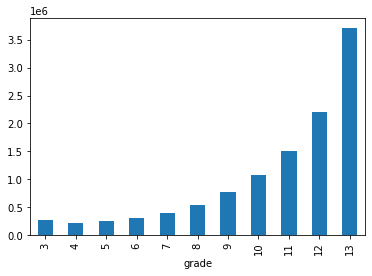

In [45]:
df_condition.price.groupby(df_condition.grade).mean().plot(kind='bar')

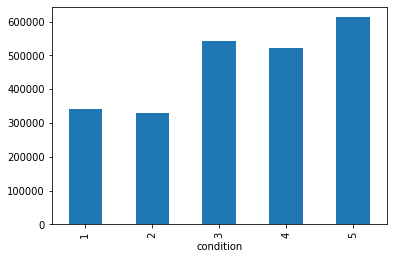

In [46]:
df_condition.price.groupby(df_condition.condition).mean().plot(kind='bar')

## Spatial Features

In [161]:
# Data scaling = 
df_price_clean['price_log'] = np.log(df_price_clean.price)

In [96]:
# Med facility
med_fac = 'https://opendata.arcgis.com/datasets/1b7f0fb5179a400f91a35c0b6bfd77c9_733.zip'
urllib.request.urlretrieve(med_fac, 'med_file.gz')
!mkdir medical
!unzip -d medical med_file.gz
med_pts = gpd.GeoDataFrame.from_file(glob.glob("medical/*.shp")[0])

mkdir: medical: File exists
Archive:  med_file.gz
replace medical/Medical_Facilities_including_Hospitals___medical_facilities_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [97]:
# Airport 
air_link = 'https://opendata.arcgis.com/datasets/41cb6a7abf744913841de20fd4b77c5d_653.zip'
urllib.request.urlretrieve(air_link, 'air_file.gz')
!mkdir airport
!unzip -d airport air_file.gz
air_poly = gpd.GeoDataFrame.from_file(glob.glob("airport/*.shp")[0])

mkdir: airport: File exists
Archive:  air_file.gz
replace airport/Airports_in_King_County___airports_area.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [98]:
# pickup ride
pickup = 'https://opendata.arcgis.com/datasets/7c8a9783f2aa4f309a44e7d706b57775_386.zip'
urllib.request.urlretrieve(pickup, 'pickup_file.gz')
!mkdir pickup
!unzip -d pickup pickup_file.gz
pickup_point = gpd.GeoDataFrame.from_file(glob.glob("pickup/*.shp")[0])

mkdir: pickup: File exists
Archive:  pickup_file.gz
replace pickup/King_County__Metro_Park_and_Ride_Lots___parkride_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [99]:
# Park
park = 'https://opendata.arcgis.com/datasets/d7411f90e0694bf89b93cdaee4e18117_884.zip'
urllib.request.urlretrieve(park, 'park_file.gz')
!mkdir park
!unzip -d park park_file.gz
parks = gpd.GeoDataFrame.from_file(glob.glob("park/*.shp")[0])

mkdir: park: File exists
Archive:  park_file.gz
replace park/Park_Label_Points___park_label_point.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [100]:
# Solid waste facility
waste = 'https://opendata.arcgis.com/datasets/f0de7329faf243cbb513622946642cbc_550.zip'
urllib.request.urlretrieve(waste, 'waste_file.gz')
!mkdir waste
!unzip -d waste waste_file.gz
waste_facility = gpd.GeoDataFrame.from_file(glob.glob("waste/*.shp")[0])

mkdir: waste: File exists
Archive:  waste_file.gz
replace waste/Solid_Waste_Facilities_Location___sw_facilities_point.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [101]:
# food facility
food = 'https://opendata.arcgis.com/datasets/ff9e4774ee8641f48cccac97dca753db_863.zip'
urllib.request.urlretrieve(food, 'food_file.gz')
!mkdir food
!unzip -d food food_file.gz
food_facility = gpd.GeoDataFrame.from_file(glob.glob("food/*.shp")[0])

mkdir: food: File exists
Archive:  food_file.gz
replace food/Food_Facilites_-_Multiple_Classes_-_For_King_County___food_facilities_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [102]:
# Schools
school_link = 'https://opendata.arcgis.com/datasets/365b0f50792c4bf6b06fc134d0494231_107.zip'
urllib.request.urlretrieve(school_link, 'school_file.gz')
!mkdir school
!unzip -d school school_file.gz
school_facility = gpd.GeoDataFrame.from_file(glob.glob("school/*.shp")[0])

mkdir: school: File exists
Archive:  school_file.gz
replace school/School_Sites_in_King_County___schsite_point.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [103]:
# Bus Stops
bus_link = 'https://opendata.arcgis.com/datasets/284a6b7a12a04016ab8b754e3b354e47_2648.zip'
urllib.request.urlretrieve(bus_link, 'bus_file.gz')
!mkdir bus
!unzip -d bus bus_file.gz
bus_stop = gpd.GeoDataFrame.from_file(glob.glob("bus/*.shp")[0])

mkdir: bus: File exists
Archive:  bus_file.gz
replace bus/Transit_Stops_for_King_County_Metro___transitstop_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [115]:
# Nearest points, convert all the geometries to a list of points
# parks
park_points = parks.geometry.tolist()
parks_p = MultiPoint(park_points)

# Food plot
food_points = food_facility.geometry.tolist()
food_p = MultiPoint(food_points)

# Med facility
med_points = med_pts.geometry.tolist()
med_p = MultiPoint(med_points)

# Airport
air_poly['center'] = air_poly.geometry.centroid
air_center = air_poly.center.tolist()
air_p = MultiPoint(air_center)

# Solid Waste
waste_points = waste_facility.geometry.tolist()
waste_p = MultiPoint(waste_points)

# Schools 
school_points = school_facility.geometry.tolist()
school_p = MultiPoint(school_points)

# Bus stop 
bus_points = bus_stop.geometry.tolist()
bus_p = MultiPoint(bus_points)

In [114]:
def nearest(housing, feature):
     # find the nearest point
    nearest_point = nearest_points(housing, feature)[1]

    return nearest_point


In [121]:
df_price_clean['Nearest_Park'] = df_price_clean.apply(lambda x: nearest(x.geometry, parks_p),
                                                      axis=1)
df_price_clean['Nearest_food'] = df_price_clean.apply(lambda x: nearest(x.geometry, food_p),
                                                    axis=1)
df_price_clean['Nearest_airport'] = df_price_clean.apply(lambda x: nearest(x.geometry, air_p),
                                                    axis=1)
df_price_clean['Nearest_waste'] = df_price_clean.apply(lambda x: nearest(x.geometry, waste_p),
                                                    axis=1)

df_price_clean['Nearest_school'] = df_price_clean.apply(lambda x: nearest(x.geometry, school_p),
                                                    axis=1)

df_price_clean['Nearest_bus'] = df_price_clean.apply(lambda x: nearest(x.geometry, bus_p),
                                                    axis=1)
df_price_clean['Nearest_med'] = df_price_clean.apply(lambda x: nearest(x.geometry, med_p),
                                                    axis=1)

In [122]:
# Finding the distance to the nearst features
def real_distance(point1, point2):
    R_earth = 6360.57
    lat1=point1.coords[0][1]
    lat2=point2.coords[0][1]
    lon1=point1.coords[0][0]
    lon2=point2.coords[0][0]
        
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = float((sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2)
    c = float(2 * atan2(sqrt(a), sqrt(1-a)))
    distance = float(R_earth * c)
    return distance

In [124]:
df_price_clean['Park_dist'] = 0.001
df_price_clean['Food_dist'] = 0.001
df_price_clean['Med_dist'] = 0.001
df_price_clean['Airport_dist'] = 0.001
df_price_clean['Waste_dist'] = 0.001
df_price_clean['School_dist'] = 0.001
df_price_clean['bus_dist'] = 0.001
for i in range(len(df_price_clean)):
    df_price_clean['Park_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_Park[i])

    df_price_clean['Food_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_food[i])
    
    df_price_clean['Med_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_med[i])
    
    df_price_clean['Airport_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_airport[i])

    df_price_clean['Waste_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_waste[i])

    df_price_clean['School_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_school[i])

    df_price_clean['bus_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_bus[i])

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/inde

## Binary: presence within 20 km ~ 12 miles (MD not per conservation)
df_price_clean['Park_20'] = df_price_clean.Park_dist<20
df_price_clean['School_20'] = df_price_clean.School_dist<20
df_price_clean['Food_20'] = df_price_clean.Food_dist<20
df_price_clean['Bus_20'] = df_price_clean.bus_dist<20

X = df_price_clean[['Park_20', 'School_20', 'Food_20', 'Bus_20', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print('R^2 Score:',round(linreg.score(X, y),2))

selector = RFE(linreg, n_features_to_select=2)
selector = selector.fit(X, y)
selector.support_, selector.ranking_, X.columns

parks = pd.get_dummies(df_price_clean.Park_20 ,prefix='park', drop_first=True)
foods = pd.get_dummies(df_price_clean.Food_20 ,prefix='food', drop_first=True)
buss = pd.get_dummies(df_price_clean.Bus_20 ,prefix='bus', drop_first=True)
schools = pd.get_dummies(df_price_clean.School_20 ,prefix='school', drop_first=True)

df_price_clean = df_price_clean.join([parks, foods, buss, schools])
df_price_clean

(0.0, 500.0)

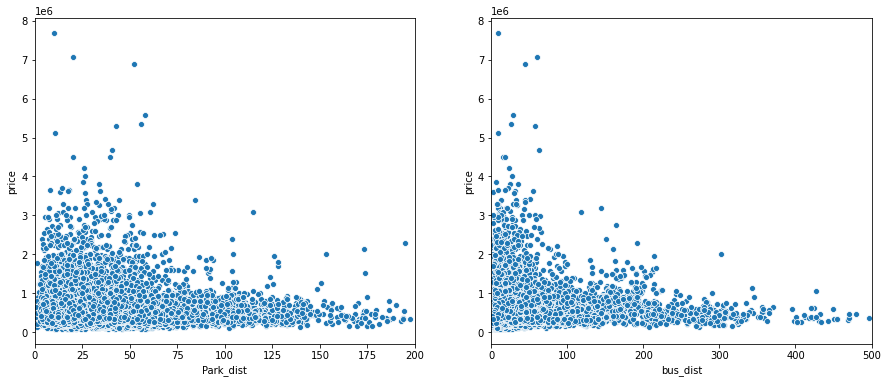

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

ax1 = sns.scatterplot(x='Park_dist', y = 'price', data=df_price_clean, ax=ax1)
ax1.set_xlim(0,200)

ax1 = sns.scatterplot(x='bus_dist', y = 'price', data=df_price_clean, ax=ax2)
ax1.set_xlim(0,500)

(0.0, 200.0)

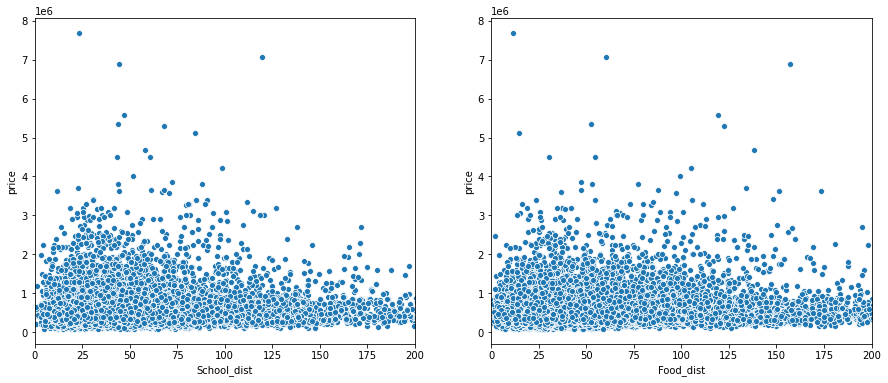

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

ax1 = sns.scatterplot(x='School_dist', y = 'price', data=df_price_clean, ax=ax1)
ax1.set_xlim(0,200)

ax1 = sns.scatterplot(x='Food_dist', y = 'price', data=df_price_clean, ax=ax2)
ax1.set_xlim(0,200)

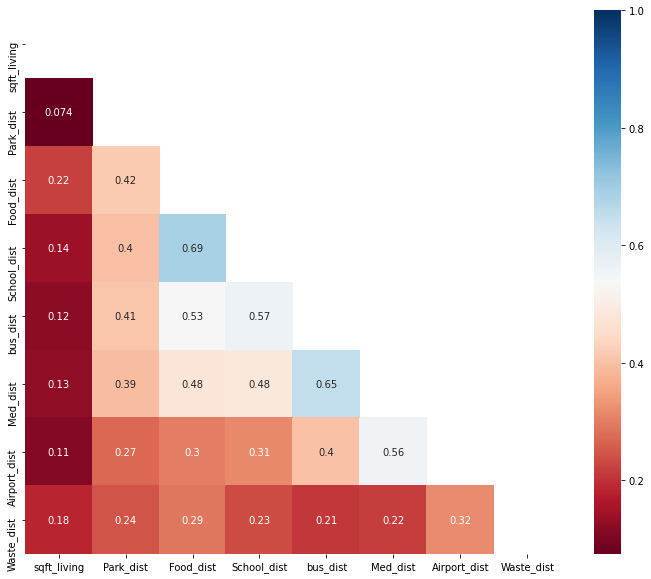

In [125]:
# Let's look at if there are colinearity
plt.figure(figsize=(12,10))
df_clean_corr = df_price_clean[['sqft_living', 'Park_dist', 'Food_dist', 'School_dist',
                                'bus_dist', 'Med_dist', 
        'Airport_dist', 'Waste_dist']]
corrs = df_clean_corr.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool))
sns.heatmap(corrs, mask=mask,
        xticklabels=corrs.columns,
        yticklabels=corrs.columns, cmap='RdBu', annot=True)

## Interpretations: school and food have the strongest correlation

In [126]:
df_price_clean.columns

Index(['id', 'price', 'sqft_living', 'lat', 'long', 'geometry', 'Nearest_Park',
       'Nearest_food', 'Nearest_airport', 'Nearest_waste', 'Nearest_school',
       'Nearest_bus', 'Park_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
       'Waste_dist', 'School_dist', 'bus_dist', 'Nearest_med'],
      dtype='object')

In [127]:
# Stats Model looking for correlation
model1 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + bus_dist + Med_dist + Airport_dist + Waste_dist + sqft_living', 
                 data=df_price_clean).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2876.
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:54:14   Log-Likelihood:            -2.9956e+05
No. Observations:               21597   AIC:                         5.991e+05
Df Residuals:                   21588   BIC:                         5.992e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.428e+04   5645.733      6.071      0.000    2.32e+04    4.53e+04
Park_dist    -1238.2631     76.892    -16.104      0.000   -1388.977   -1087.549
School_dist    155.8028     49.261      3.163      0.002      59.247     252.359
Food_dist     -419.3575     50.557     -8.295      0.000    -518.453    -320.262
bus_dist       -64.0632     39.238     -1.633      0.103    -140.972      12.846
Med_dist       -28.3401     13.961     -2.030      0.042     -55.705      -0.975
Airport_dist     5.1264      3.995      1.283      0.199      -2.703      12.956
Waste_dist    -128.2367     10.237    -12.527      0.000    -148.301    -108.172
sqft_living    293.1440      1.963    149.369      0.000     289.297     296.991
==============================================================================
Omnibus:                    14717.536   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           550841.924
Skew:                           2.788   Prob(JB):                         0.00
Kurtosis:                      27.105   Cond. No.                     8.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation: 
Distance to bus stops and airports seem to be not very signicant. It can be possible that many people do drive in Kings County.

In [128]:
model2 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + Med_dist + Waste_dist + sqft_living', 
                 data=df_price_clean).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     3834.
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:54:34   Log-Likelihood:            -2.9956e+05
No. Observations:               21597   AIC:                         5.991e+05
Df Residuals:                   21590   BIC:                         5.992e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     3.85e+04   5200.780      7.402      0.000    2.83e+04    4.87e+04
Park_dist   -1249.4002     76.405    -16.352      0.000   -1399.160   -1099.641
School_dist   139.8930     48.028      2.913      0.004      45.754     234.032
Food_dist    -431.8471     50.117     -8.617      0.000    -530.080    -333.614
Med_dist      -30.7187     11.263     -2.727      0.006     -52.795      -8.643
Waste_dist   -125.2507      9.963    -12.571      0.000    -144.779    -105.722
sqft_living   293.1871      1.962    149.403      0.000     289.341     297.034
==============================================================================
Omnibus:                    14691.480   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           548756.513
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      27.060   Cond. No.                     6.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation: 
1. Collinearity improved
2. P-values are generally all smaller

In [129]:
# if only community features
model3 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + bus_dist + Med_dist + Airport_dist + Waste_dist', 
                 data=df_price_clean).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     48.98
Date:                Sat, 05 Sep 2020   Prob (F-statistic):           1.51e-69
Time:                        15:54:39   Log-Likelihood:            -3.0722e+05
No. Observations:               21597   AIC:                         6.145e+05
Df Residuals:                   21589   BIC:                         6.145e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.313e+05   6503.872     81.688      0.000    5.19e+05    5.44e+05
Park_dist    -1715.0938    109.552    -15.656      0.000   -1929.823   -1500.364
School_dist    -15.4073     70.226     -0.219      0.826    -153.056     122.242
Food_dist      695.6019     71.303      9.756      0.000     555.842     835.361
bus_dist       -72.4070     55.952     -1.294      0.196    -182.077      37.263
Med_dist         6.7618     19.906      0.340      0.734     -32.255      45.778
Airport_dist    14.6637      5.695      2.575      0.010       3.500      25.827
Waste_dist      61.1386     14.485      4.221      0.000      32.748      89.529
==============================================================================
Omnibus:                    19170.142   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1166361.536
Skew:                           4.036   Prob(JB):                         0.00
Kurtosis:                      38.085   Cond. No.                     3.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [181]:
# Price log
model4 = smf.ols(formula='price_log ~ Park_dist + Food_dist + bus_dist + Med_dist + Airport_dist + Waste_dist', 
                 data=df_price_clean).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     112.4
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          3.01e-140
Time:                        23:43:47   Log-Likelihood:                -16460.
No. Observations:               21597   AIC:                         3.293e+04
Df Residuals:                   21590   BIC:                         3.299e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.9659      0.009   1410.983      0.000      12.948      12.984
Park_dist       -0.0028      0.000    -17.974      0.000      -0.003      -0.002
Food_dist        0.0010   8.74e-05     11.019      0.000       0.001       0.001
bus_dist        -0.0002   7.76e-05     -2.260      0.024      -0.000   -2.33e-05
Med_dist        -0.0001   2.83e-05     -4.199      0.000      -0.000   -6.33e-05
Airport_dist     0.0001    8.1e-06     15.129      0.000       0.000       0.000
Waste_dist       0.0001   2.06e-05      5.637      0.000    7.58e-05       0.000
==============================================================================
Omnibus:                     1066.419   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1418.108
Skew:                           0.486   Prob(JB):                    1.15e-308
Kurtosis:                       3.795   Cond. No.                     3.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model testing

In [183]:
# Model testing
X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 
                    'Waste_dist', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5126316208024582

In [184]:
# Cross-validation
kfold = model_selection.KFold(n_splits=10, random_state=123)
model_kfold = LinearRegression()
results_kfold = model_selection.cross_val_score(model_kfold, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 51.24%


## Polynomial

In [153]:
X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 
                    'Waste_dist', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)

In [157]:
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)


degree 2 0.5542517927132082
degree 3 0.574384934979348
degree 4 0.35741191281417894
degree 5 -59.93251051402609


In [162]:
# Log?
X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 
                    'Waste_dist', 'sqft_living']]
y = df_price_clean['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)

degree 2 0.5173876350007633
degree 3 0.5407733873787348
degree 4 0.3041245398054211
degree 5 -136.76367652809768


## Spatial Lag
Price per square footage

In [163]:
# Zipcode boundary
zip_link = 'https://opendata.arcgis.com/datasets/e6c555c6ae7542b2bdec92485892b6e6_113.zip'
urllib.request.urlretrieve(zip_link, 'zip_file.gz')
!mkdir zipcode
!unzip -d zipcode zip_file.gz
zip_poly = gpd.GeoDataFrame.from_file(glob.glob("zipcode/*.shp")[0])

Archive:  zip_file.gz
  inflating: zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shx  
  inflating: zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.dbf  
  inflating: zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.prj  
  inflating: zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp  
  inflating: zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.xml  
 extracting: zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.cpg  


In [191]:
df_spatial = df[['id', 'price', 'sqft_living', 'lat', 'long', 'zipcode']]
df_spatial_geo = gpd.GeoDataFrame(df_spatial, 
                              geometry=gpd.points_from_xy(df_spatial.long, df_spatial.lat))
df_spatial.zipcode = df_spatial.zipcode.astype(int)
zip_poly.ZIPCODE = zip_poly.ZIPCODE.astype(int)

/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [192]:
df_zip_join = pd.merge(df_spatial_geo, zip_poly, left_on = 'zipcode', 
                       right_on = 'ZIPCODE', how='left' )
group_zip = df_zip_join.groupby(['ZIPCODE'])['price', 'sqft_living'].agg('median')
group_df = pd.DataFrame(group_zip).reset_index()

In [193]:
group_new = pd.merge(group_df, zip_poly, on='ZIPCODE', how='left')
group_geo = gpd.GeoDataFrame(group_new, geometry = 'geometry')

<Figure size 1080x720 with 0 Axes>

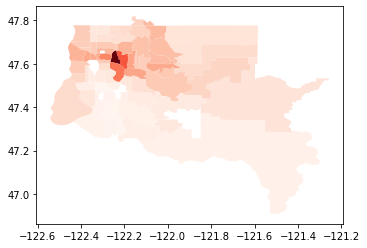

In [197]:
plt.figure(figsize=(15,10))
group_geo.plot(column='price', cmap='Reds')

In [207]:
# Autocorrection
df = group_geo
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'
y = df['price']
ylag = lps.weights.lag_spatial(wq, y)

In [208]:
ylagq5 = mc.Quantiles(ylag, k=6)

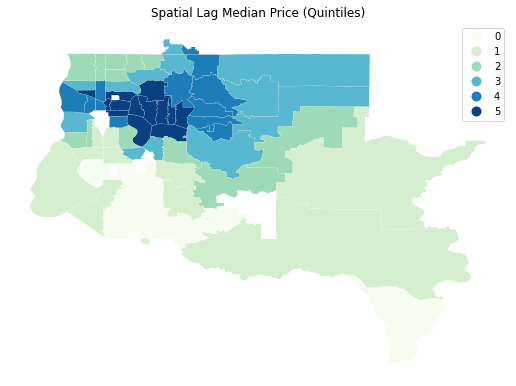

In [209]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

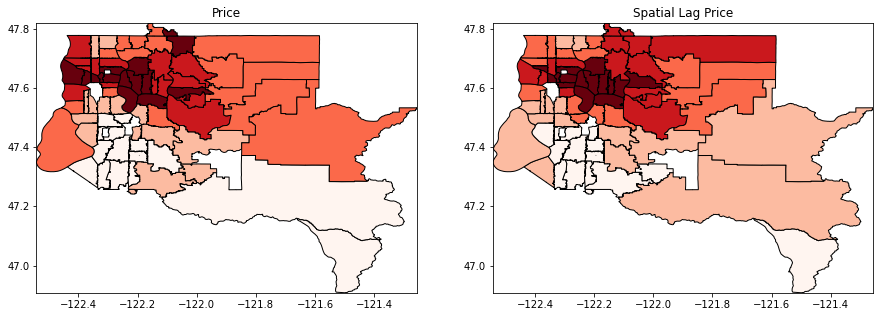

In [219]:
df['lag_median_pri'] = ylag
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
df.plot(column='price', ax=ax1, edgecolor='k',
        scheme="quantiles",  k=5, cmap='Reds')
ax1.axis(df.total_bounds[np.asarray([0,2,1,3])])
ax1.set_title("Price")
df.plot(column='lag_median_pri', ax=ax2, edgecolor='k',
        scheme='quantiles', cmap='Reds', k=5)
ax2.axis(df.total_bounds[np.asarray([0,2,1,3])])
ax2.set_title("Spatial Lag Price")

plt.show()